In [1]:
import numpy as np
from astroplan import AirmassConstraint, AtNightConstraint, Transitioner, SequentialScheduler, ObservingBlock, \
    PriorityScheduler
from astroplan.plots import plot_schedule_airmass
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib import pyplot as plt
from sqlalchemy import create_engine

from utils import *

from ossaf.assess.const import MAX_PRIORITY


engine = create_engine('sqlite:///ossaf/data/tyc2.sqlite', echo=False)
conn = engine.connect()

In [2]:
date_string = observing_date.strftime("%Y_%m_%d_%H_%M_%S")
# Chech if table exist. if exist jump to next step. 如果当前日期的表已经存在，就不再创建
if not engine.dialect.has_table(conn, f"rise_in_night_{date_string}"):
    # Create table
    # Get tycho stars
    limit_magnitude = 8
    tycho = pd.read_sql_query(f"SELECT * FROM tyc2 WHERE VTmag < {limit_magnitude}", con=conn, chunksize=2000)
    for chunk in tycho:
        tycho_skycoord = SkyCoord(ra=chunk.RA_ICRS_.to_numpy() * u.deg, dec=chunk.DE_ICRS_.to_numpy() * u.deg,
                                  frame='icrs')
        target = FixedTarget(coord=tycho_skycoord, name=chunk.ID)

        tycho_rise_time = observer.target_rise_time(obs_start, target, which='next', horizon=30 * u.deg)
        # print(tycho_rise_time)

        visible_star = chunk.loc[tycho_rise_time < obs_end].copy()

        visible_star['priority'] = np.random.randint(1, MAX_PRIORITY, size=len(visible_star))
        visible_star['rise_time'] = tycho_rise_time[tycho_rise_time < obs_end].datetime

        visible_star.to_sql(f"rise_in_night_{date_string}", con=conn, if_exists='append', index=False)


In [3]:
# 获取当前日期可见的恒星,随机取出100个
visible_stars = pd.read_sql_query(f"SELECT * FROM rise_in_night_{date_string}", con=conn)

visible_stars = visible_stars.sample(100, random_state=42)
visible_stars.to_sql(f"candidate_{date_string}", con=conn, if_exists='replace', index=False)

visible_icrs = SkyCoord(ra=visible_stars.RA_ICRS_.to_numpy() * u.deg, dec=visible_stars.DE_ICRS_.to_numpy() * u.deg,
                        frame='icrs')
print(len(visible_icrs))

100


In [4]:
# 恒星转为观测快,每个观测块5分钟
blocks = []
for star, name, p, (_, v) in zip(visible_icrs, visible_stars.ID, visible_stars.priority, visible_stars.iterrows()):
    target = FixedTarget(coord=star, name=name)

    b = ObservingBlock(target, 5 * u.min, priority=p)
    blocks.append(b)

    print(star, v.rise_time, p)

<SkyCoord (ICRS): (ra, dec) in deg
    (343.51905139, 19.59797639)> 2023-06-08 16:54:59.478047 1
<SkyCoord (ICRS): (ra, dec) in deg
    (307.53037806, 19.4301525)> 2023-06-08 14:32:06.644482 2
<SkyCoord (ICRS): (ra, dec) in deg
    (285.42016806, -5.73902333)> 2023-06-08 15:00:20.300353 2
<SkyCoord (ICRS): (ra, dec) in deg
    (8.12505278, 51.72825917)> 2023-06-08 16:38:15.986407 3
<SkyCoord (ICRS): (ra, dec) in deg
    (336.69375333, 21.86967861)> 2023-06-08 16:19:46.168407 4
<SkyCoord (ICRS): (ra, dec) in deg
    (332.16866889, 0.33807639)> 2023-06-08 17:30:18.634486 1
<SkyCoord (ICRS): (ra, dec) in deg
    (313.38883722, 31.62614639)> 2023-06-08 14:13:35.919225 4
<SkyCoord (ICRS): (ra, dec) in deg
    (348.62714944, 20.44226889)> 2023-06-08 17:12:22.921029 3
<SkyCoord (ICRS): (ra, dec) in deg
    (357.98283889, 40.74509694)> 2023-06-08 16:40:16.050692 2
<SkyCoord (ICRS): (ra, dec) in deg
    (284.69709, -5.63484361)> 2023-06-08 14:56:46.569064 1
<SkyCoord (ICRS): (ra, dec) in deg
  

In [5]:
# create the list of constraints that all targets must satisfy
global_constraints = [AirmassConstraint(max=3, boolean_constraint=False),
                      AtNightConstraint.twilight_astronomical()]

slew_rate = 3 * u.deg / u.second  # 1.2M 最大转速是 6 deg/s
transitioner = Transitioner(slew_rate,
                            {'filter': {('B', 'G'): 10 * u.second,
                                        ('G', 'R'): 10 * u.second,
                                        'default': 30 * u.second}})



In [8]:
schedule = Schedule(obs_start, obs_end)
priority_scheduler = PriorityScheduler(constraints=global_constraints,
                                       observer=observer,
                                       transitioner=transitioner)
priority_scheduler(blocks, schedule)

Schedule containing 41 observing blocks between 2023-06-08 13:35:16.683 and 2023-06-08 17:32:01.974

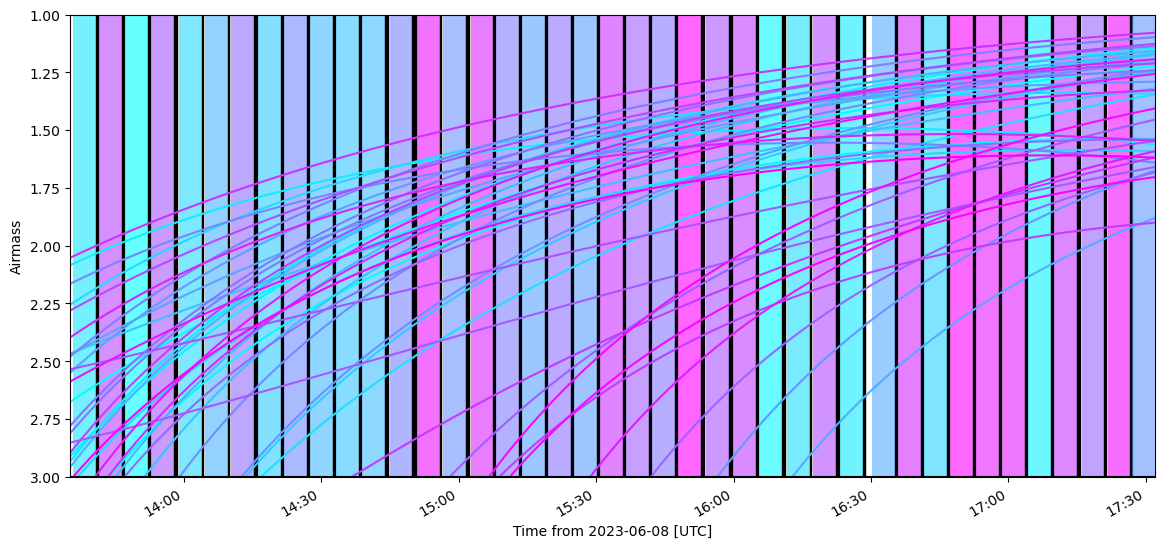

In [9]:
# plot the schedule with the airmass of the targets
plt.figure(figsize=(14, 6))
plot_schedule_airmass(schedule)
# plt.legend(loc="upper right")
plt.show()

In [10]:
schedule.to_table()

target,start time (UTC),end time (UTC),duration (minutes),ra,dec,configuration
str15,str23,str23,float64,str32,str32,object
1640-1831-1,2023-06-08 13:35:56.683,2023-06-08 13:40:56.683,5.000000000000142,306.85653472,18.96814083,{}
TransitionBlock,2023-06-08 13:40:56.683,2023-06-08 13:41:16.683,0.33333333333327886,,,[]
1079-3297-1,2023-06-08 13:41:36.684,2023-06-08 13:46:36.684,5.000000000000142,299.48394,11.41471,{}
TransitionBlock,2023-06-08 13:46:36.684,2023-06-08 13:46:56.684,0.33333333333327886,,,[]
3632-2011-1,2023-06-08 13:47:16.684,2023-06-08 13:52:16.684,5.000000000000142,337.81258556,50.87234833,{}
TransitionBlock,2023-06-08 13:52:16.684,2023-06-08 13:52:36.684,0.33333333333327886,,,[]
4038-622-1,2023-06-08 13:52:56.684,2023-06-08 13:57:56.684,5.000000000000142,20.27161972,64.65818556,{}
TransitionBlock,2023-06-08 13:57:56.684,2023-06-08 13:58:36.684,0.6666666666665577,,,[]
451-985-1,2023-06-08 13:58:56.684,2023-06-08 14:03:56.684,5.000000000000142,281.15704639,2.12095556,{}


In [11]:
x = schedule2df_ex(schedule)

In [13]:
x.to_sql(f"priority_schedule_{date_string}", con=conn, if_exists='replace', index=False)

41

In [14]:
seq_scheduler = SequentialScheduler(constraints=global_constraints,
                                    observer=observer,
                                    transitioner=transitioner)

schedule = Schedule(obs_start, obs_end)
seq_scheduler(blocks, schedule)


Schedule containing 46 observing blocks between 2023-06-08 13:35:16.683 and 2023-06-08 17:32:01.974

In [15]:
schedule.to_table()

target,start time (UTC),end time (UTC),duration (minutes),ra,dec,configuration
str15,str23,str23,float64,str32,str32,object
3180-149-1,2023-06-08 13:35:16.683,2023-06-08 13:40:16.683,5.000000000000142,316.94809472,44.96424389,{}
TransitionBlock,2023-06-08 13:40:16.683,2023-06-08 13:40:38.315,0.36052909005748646,,,[]
5091-713-1,2023-06-08 13:40:38.315,2023-06-08 13:45:38.315,4.999999999999982,269.19895222,-4.08180333,{}
TransitionBlock,2023-06-08 13:45:38.315,2023-06-08 13:45:47.574,0.15431469783599994,,,[]
6201-50-1,2023-06-08 13:45:47.574,2023-06-08 13:50:47.574,5.000000000000142,243.29643417,-15.11691806,{}
TransitionBlock,2023-06-08 13:50:47.574,2023-06-08 13:51:08.701,0.3521095380500583,,,[]
1623-613-1,2023-06-08 13:51:08.701,2023-06-08 13:56:08.701,5.000000000000142,297.18437778,19.66108139,{}
TransitionBlock,2023-06-08 13:56:08.701,2023-06-08 13:56:18.609,0.1651370052919532,,,[]
5098-149-1,2023-06-08 13:56:18.609,2023-06-08 14:01:18.609,5.000000000000142,275.59914861,-1.20229806,{}


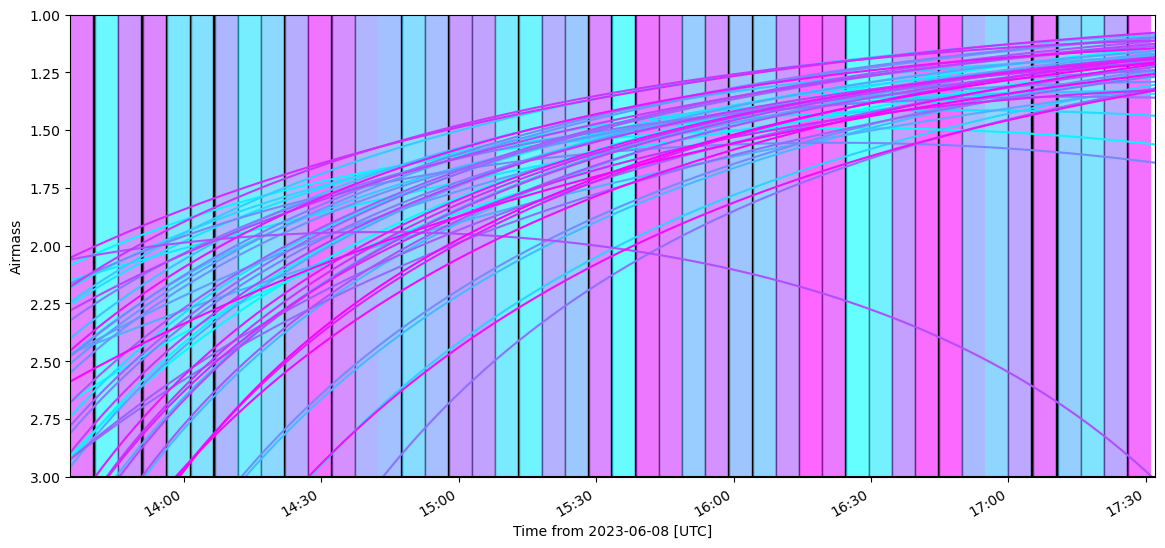

In [16]:
# plot the schedule with the airmass of the targets
plt.figure(figsize=(14, 6))
plot_schedule_airmass(schedule)
# plt.legend(loc="upper right")
plt.show()

In [17]:
x = schedule2df_ex(schedule)
x.to_sql(f"sequential_schedule_{date_string}", con=conn, if_exists='replace', index=False)


46